# Machine Learning Experiment 2: Multiple, Lasso, and Ridge Regression on Insurance Premium Prediction

**Experiment Title:** Predicting Medical Insurance Premiums Using Regularized Regression Models  
**Date:** February 2026  
**Objective:** To implement and compare Multiple Linear Regression, Lasso Regression, and Ridge Regression models on the Insurance Premium dataset for predicting medical expenses.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

## 1. Dataset Source

**Dataset Name:** Insurance Premium Prediction Dataset  
**Source:** https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction/data  
**Original Source:** Professor Eric Suess, California State University, East Bay (Spring 2017)  
**File Size:** 50.26 kB  
**License:** Unknown

## 2. Dataset Description

The Insurance Premium Prediction dataset is designed to predict medical insurance costs based on individual characteristics. This is a classic dataset used for regression analysis and predicting continuous target variables.

### Dataset Overview:
- **Number of Records:** 1,338 observations (individuals)
- **Number of Features:** 6 input features + 1 target variable
- **Target Variable:** `charges` - individual medical costs billed by health insurance
- **Data Types:** Mix of numerical and categorical features

### Features Description:
1. **age** (numerical): Age of the individual in years
   - Range: 18-64 years
   - Type: Continuous

2. **sex** (categorical): Biological sex (male, female)
   - Binary categorical variable
   - Impact on insurance costs

3. **bmi** (numerical): Body Mass Index
   - Range: 15.96-53.13 kg/m²
   - Numerical measure of body fat

4. **children** (numerical): Number of children/dependents covered by insurance
   - Range: 0-5 children
   - Discrete numerical variable

5. **smoker** (categorical): Smoking status (yes, no)
   - Binary categorical variable
   - Major factor in insurance costs

6. **region** (categorical): US geographic region (northeast, northwest, southeast, southwest)
   - Four-level categorical variable
   - Geographic location

### Target Variable:
- **charges** (numerical): Individual medical costs charged by health insurance
   - Continuous numerical variable
   - Range varies based on individual characteristics
   - Typically positively skewed due to high-cost cases

### Data Characteristics:
- **No Missing Values:** The dataset is clean with no missing entries
- **Class Balance:** Not applicable (regression problem)
- **Imbalance:** The target variable may have outliers (very high medical costs)
- **Multicollinearity:** Potential correlation between age, BMI, and charges

In [33]:
# Load the insurance premium dataset
# Note: Download from Kaggle and place in the same directory as this notebook
try:
    df = pd.read_csv('insurance.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file 'insurance.csv' not found.")
    print("Please download from: https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction/data")
    print("and place it in the same directory as this notebook.")
    df = None

Dataset loaded successfully!


In [34]:
if df is not None:
    print("Dataset Shape:", df.shape)
    print("\n" + "="*80)
    print("First Few Rows:")
    print(df.head())
    print("\n" + "="*80)
    print("Data Types:")
    print(df.dtypes)
    print("\n" + "="*80)
    print("Missing Values:")
    print(df.isnull().sum())
    print("\n" + "="*80)
    print("Statistical Summary:")
    print(df.describe())

Dataset Shape: (1338, 7)

First Few Rows:
   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86

Data Types:
age           int64
sex             str
bmi         float64
children      int64
smoker          str
region          str
expenses    float64
dtype: object

Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

Statistical Summary:
               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121

Target Variable Analysis:
Target Variable: expenses
Mean: $13270.42
Median: $9382.03
Std Dev: $12110.01
Min: $1121.87
Max: $63770.43


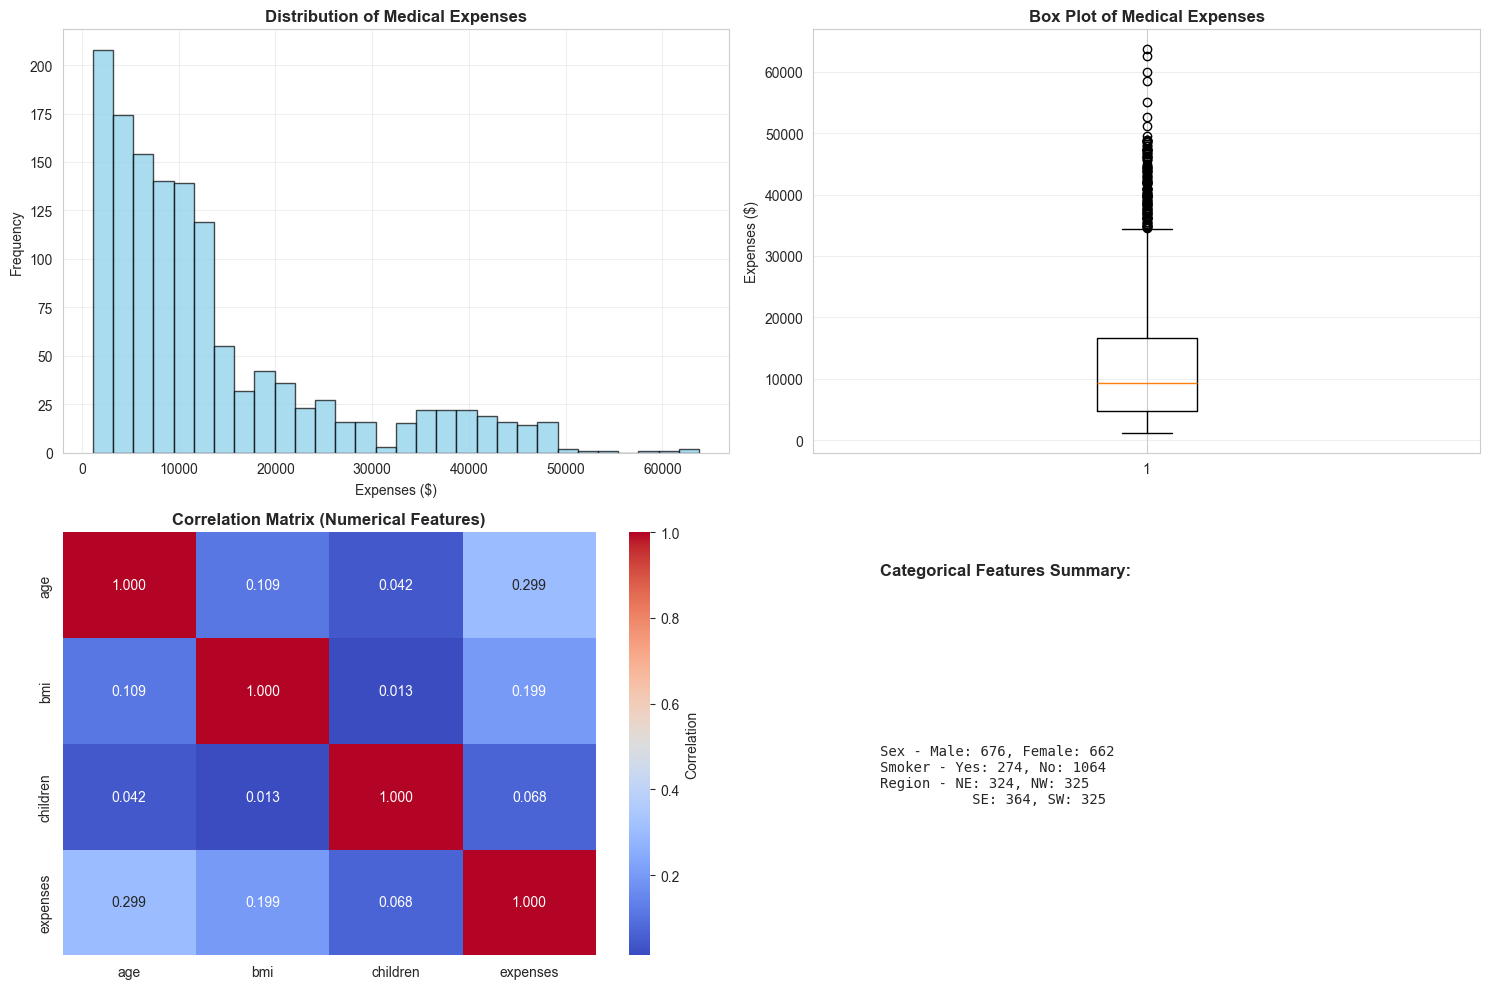

In [35]:
if df is not None:
    # Target variable analysis
    print("Target Variable Analysis:")
    print(f"Target Variable: expenses")
    print(f"Mean: ${df['expenses'].mean():.2f}")
    print(f"Median: ${df['expenses'].median():.2f}")
    print(f"Std Dev: ${df['expenses'].std():.2f}")
    print(f"Min: ${df['expenses'].min():.2f}")
    print(f"Max: ${df['expenses'].max():.2f}")
    
    # Visualize target distribution and correlations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram
    axes[0, 0].hist(df['expenses'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Medical Expenses', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Expenses ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot(df['expenses'], vert=True)
    axes[0, 1].set_title('Box Plot of Medical Expenses', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylabel('Expenses ($)')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Correlation heatmap
    correlation_data = df[['age', 'bmi', 'children', 'expenses']].corr()
    sns.heatmap(correlation_data, annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1, 0], cbar_kws={'label': 'Correlation'})
    axes[1, 0].set_title('Correlation Matrix (Numerical Features)', fontweight='bold', fontsize=12)
    
    # Categorical features distribution
    categorical_features = df[['sex', 'smoker', 'region']].apply(pd.Series.value_counts)
    axes[1, 1].axis('off')
    axes[1, 1].text(0.1, 0.9, 'Categorical Features Summary:', fontsize=12, fontweight='bold', transform=axes[1, 1].transAxes)
    summary_text = f"Sex - Male: {df['sex'].value_counts().get('male', 0)}, Female: {df['sex'].value_counts().get('female', 0)}\n"
    summary_text += f"Smoker - Yes: {df['smoker'].value_counts().get('yes', 0)}, No: {df['smoker'].value_counts().get('no', 0)}\n"
    summary_text += f"Region - NE: {(df['region']=='northeast').sum()}, NW: {(df['region']=='northwest').sum()}\n"
    summary_text += f"           SE: {(df['region']=='southeast').sum()}, SW: {(df['region']=='southwest').sum()}"
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, transform=axes[1, 1].transAxes, verticalalignment='top', family='monospace')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Dataset not loaded. Please download 'insurance.csv' from:")
    print("https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction/data")
    print("Place it in the same directory as this notebook to run the analysis.")

## 3. Mathematical Formulation of Algorithms

### 3.1 Multiple Linear Regression

Multiple Linear Regression extends simple linear regression to multiple predictor variables:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

In matrix form:
$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$$

Where:
- $\mathbf{y}$ is the target vector (n × 1)
- $\mathbf{X}$ is the feature matrix (n × (p+1)) with intercept column
- $\boldsymbol{\beta}$ is the coefficient vector (p+1 × 1)
- $\boldsymbol{\epsilon}$ is the error vector (n × 1)

**Cost Function (OLS):**
$$J(\boldsymbol{\beta}) = \frac{1}{2m} \sum_{i=1}^{m} (h_\beta(\mathbf{x}^{(i)}) - y^{(i)})^2 = \frac{1}{2m} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|_2^2$$

**Closed-form Solution:**
$$\boldsymbol{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

### 3.2 Lasso Regression (L1 Regularization)

Lasso (Least Absolute Shrinkage and Selection Operator) adds L1 penalty to the cost function:

$$J(\boldsymbol{\beta}) = \frac{1}{2m} \sum_{i=1}^{m} (h_\beta(\mathbf{x}^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{p} |\beta_j|$$

Or in compact form:
$$J(\boldsymbol{\beta}) = \frac{1}{2m} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1$$

Where:
- $\lambda$ is the regularization parameter (controls strength of penalty)
- $\|\boldsymbol{\beta}\|_1 = \sum_{j=1}^{p} |\beta_j|$ is the L1 norm

**Key Property:** Lasso performs feature selection by driving coefficients to exactly zero, useful for identifying important features.

### 3.3 Ridge Regression (L2 Regularization)

Ridge Regression adds L2 penalty to the cost function:

$$J(\boldsymbol{\beta}) = \frac{1}{2m} \sum_{i=1}^{m} (h_\beta(\mathbf{x}^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{p} \beta_j^2$$

Or in compact form:
$$J(\boldsymbol{\beta}) = \frac{1}{2m} \|\mathbf{X}\boldsymbol{\beta} - \mathbf{y}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_2^2$$

Where:
- $\lambda$ is the regularization parameter
- $\|\boldsymbol{\beta}\|_2^2 = \sum_{j=1}^{p} \beta_j^2$ is the squared L2 norm

**Closed-form Solution:**
$$\boldsymbol{\beta} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

**Key Property:** Ridge shrinks coefficients proportionally but rarely sets them to exactly zero.

## 4. Algorithm Limitations

### 4.1 Multiple Linear Regression Limitations

1. **Assumes Linear Relationships:** Cannot capture non-linear patterns in data.

2. **Sensitive to Multicollinearity:** Highly correlated features lead to unstable and unreliable coefficient estimates. The matrix $(\mathbf{X}^T\mathbf{X})$ becomes ill-conditioned.

3. **Sensitive to Outliers:** Extreme values disproportionately affect coefficient estimates and predictions.

4. **Assumes Homoscedasticity:** Assumes constant variance of residuals across all feature values. Violated when variance changes with features.

5. **Feature Scaling Dependent:** Coefficients are scaled with feature magnitudes, making interpretation difficult and comparison across features problematic.

6. **No Feature Selection:** Includes all features, even irrelevant ones, potentially reducing interpretability and generalization.

7. **Overfitting Risk:** On high-dimensional data with many features, the model can overfit to training data.

### 4.2 Lasso Regression Limitations

1. **Arbitrary Feature Selection:** When features are highly correlated, Lasso arbitrarily selects one and sets others to zero, reducing interpretability.

2. **Non-differentiable at Zero:** The L1 norm creates a non-smooth optimization problem, making gradient-based optimization challenging.

3. **Computationally Expensive:** Requires specialized algorithms (coordinate descent) for efficient solving.

4. **Single Alpha Dependency:** Performance highly sensitive to the regularization parameter $\lambda$. Poor choice can lead to underfitting or overfitting.

5. **Sample Size Requirement:** Requires sufficient samples relative to features. With $n < p$, performance may degrade.

6. **Not Ideal for Group-Wise Correlated Features:** Unlike Group Lasso, cannot handle groups of correlated features well.

### 4.3 Ridge Regression Limitations

1. **No Feature Selection:** Ridge shrinks coefficients but rarely sets them to zero, keeping all features in the model.

2. **Interpretation Challenge:** With many features, identifying truly important predictors is difficult due to distributed shrinkage.

3. **Alpha Parameter Tuning:** Sensitive to $\lambda$ selection; poor tuning leads to over/underfitting.

4. **Computational Cost:** Computing $(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}$ can be expensive for large datasets.

5. **Bias-Variance Trade-off:** Adds bias to reduce variance; incorrect $\lambda$ can increase total error.

## 5. Methodology / Workflow

### Experiment Workflow

```
┌─────────────────────────────┐
│   1. Load Dataset           │
│   (Insurance Data)          │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 2. Exploratory Data         │
│    Analysis (EDA)           │
│  - Data profiling           │
│  - Correlation analysis     │
│  - Distribution analysis    │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 3. Data Preprocessing       │
│  - Handle missing values    │
│  - Encode categorical vars  │
│  - Feature scaling          │
│  - Check for outliers       │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 4. Train-Test Split        │
│  - 70% training            │
│  - 30% testing             │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 5. Model Training           │
│  - Multiple Regression      │
│  - Lasso Regression         │
│  - Ridge Regression         │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 6. Model Evaluation         │
│  - Performance metrics      │
│  - Visualizations           │
│  - Residual analysis        │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 7. Hyperparameter Tuning    │
│  - Alpha parameter tuning   │
│  - GridSearchCV             │
│  - Cross-validation         │
└──────────────┬──────────────┘
               │
               ▼
┌─────────────────────────────┐
│ 8. Model Comparison &       │
│    Final Analysis           │
└─────────────────────────────┘
```

### Detailed Process:

1. **Data Loading:** Import insurance dataset
2. **EDA:** Analyze distributions, correlations, and relationships
3. **Preprocessing:** Encode categoricals, scale features, split data
4. **Model Training:** Train three regression models
5. **Evaluation:** Calculate R², MSE, RMSE, MAE metrics
6. **Tuning:** Optimize alpha parameters for Lasso and Ridge
7. **Comparison:** Compare model performance and feature importance
8. **Conclusions:** Identify best model and provide insights

## 6. Data Preprocessing

### 6.1 Data Cleaning and Feature Engineering

In [36]:
if df is not None:
    df_processed = df.copy()
    
    # Identify categorical and numerical columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove target variable from numerical columns for processing
    if 'expenses' in numerical_cols:
        numerical_cols.remove('expenses')
    
    print("Categorical Columns:", categorical_cols)
    print("Numerical Columns:", numerical_cols)
    print("Target Variable: expenses")
    print(f"\nTotal Features: {len(categorical_cols) + len(numerical_cols)}")

Categorical Columns: ['sex', 'smoker', 'region']
Numerical Columns: ['age', 'bmi', 'children']
Target Variable: expenses

Total Features: 6


In [37]:
if df is not None:
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
    
    print("Categorical variables encoded successfully!")
    print("\nEncoding Details:")
    for col in categorical_cols:
        le = label_encoders[col]
        print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    print("\nData after encoding:")
    print(df_processed.head())
    print("\nData types:")
    print(df_processed.dtypes)

Categorical variables encoded successfully!

Encoding Details:
sex: {'female': np.int64(0), 'male': np.int64(1)}
smoker: {'no': np.int64(0), 'yes': np.int64(1)}
region: {'northeast': np.int64(0), 'northwest': np.int64(1), 'southeast': np.int64(2), 'southwest': np.int64(3)}

Data after encoding:
   age  sex   bmi  children  smoker  region  expenses
0   19    0  27.9         0       1       3  16884.92
1   18    1  33.8         1       0       2   1725.55
2   28    1  33.0         3       0       2   4449.46
3   33    1  22.7         0       0       1  21984.47
4   32    1  28.9         0       0       1   3866.86

Data types:
age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
expenses    float64
dtype: object


In [38]:
if df is not None:
    # Separate features and target
    X = df_processed.drop('expenses', axis=1)
    y = df_processed['expenses']
    
    # Train-test split (70-30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    print("Data Split Summary:")
    print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
    print(f"Number of features: {X_train.shape[1]}")
    
    print("\nFeature names:", list(X.columns))
    print("\nTraining set target statistics:")
    print(f"  Mean: ${y_train.mean():.2f}")
    print(f"  Std: ${y_train.std():.2f}")
    print(f"  Min: ${y_train.min():.2f}")
    print(f"  Max: ${y_train.max():.2f}")
    
    print("\nTesting set target statistics:")
    print(f"  Mean: ${y_test.mean():.2f}")
    print(f"  Std: ${y_test.std():.2f}")
    print(f"  Min: ${y_test.min():.2f}")
    print(f"  Max: ${y_test.max():.2f}")

Data Split Summary:
Training set size: 936 samples (70.0%)
Testing set size: 402 samples (30.0%)
Number of features: 6

Feature names: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

Training set target statistics:
  Mean: $13379.16
  Std: $12108.88
  Min: $1121.87
  Max: $62592.87

Testing set target statistics:
  Mean: $13017.25
  Std: $12123.94
  Min: $1131.51
  Max: $63770.43


In [39]:
if df is not None:
    # Feature Scaling using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to dataframe
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    print("Feature Scaling Completed!")
    print("\nScaled Training Set Statistics:")
    print(X_train_scaled.describe())
    print("\nScaled Features (first 5 rows of training set):")
    print(X_train_scaled.head())

Feature Scaling Completed!

Scaled Training Set Statistics:
                age           sex           bmi      children        smoker  \
count  9.360000e+02  9.360000e+02  9.360000e+02  9.360000e+02  9.360000e+02   
mean  -1.005843e-16  1.252559e-16  2.467162e-16 -4.554761e-17 -2.277381e-17   
std    1.000535e+00  1.000535e+00  1.000535e+00  1.000535e+00  1.000535e+00   
min   -1.501628e+00 -1.025978e+00 -2.426719e+00 -9.150110e-01 -5.129892e-01   
25%   -8.640739e-01 -1.025978e+00 -7.247891e-01 -9.150110e-01 -5.129892e-01   
50%   -1.400137e-02  9.746794e-01 -5.736562e-02 -8.991437e-02 -5.129892e-01   
75%    9.069105e-01  9.746794e-01  6.476004e-01  7.351822e-01 -5.129892e-01   
max    1.756983e+00  9.746794e-01  3.763634e+00  3.210472e+00  1.949359e+00   

             region  
count  9.360000e+02  
mean  -4.554761e-17  
std    1.000535e+00  
min   -1.327527e+00  
25%   -1.327527e+00  
50%   -4.290707e-01  
75%    4.693860e-01  
max    1.367843e+00  

Scaled Features (first 5 rows

## 7. Model Training - Multiple Linear Regression

In [40]:
if df is not None:
    # Train Multiple Linear Regression model
    mult_reg = LinearRegression()
    mult_reg.fit(X_train_scaled, y_train)
    
    print("Multiple Linear Regression Model Training Complete!")
    print(f"\nModel Parameters:")
    print(f"Intercept: ${mult_reg.intercept_:.2f}")
    print(f"Number of features: {len(mult_reg.coef_)}")
    
    # Make predictions
    y_train_pred_mult = mult_reg.predict(X_train_scaled)
    y_test_pred_mult = mult_reg.predict(X_test_scaled)
    
    print("\nPrediction Summary:")
    print(f"Training predictions shape: {y_train_pred_mult.shape}")
    print(f"Testing predictions shape: {y_test_pred_mult.shape}")
    
    # Feature coefficients
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': mult_reg.coef_
    }).sort_values('Coefficient', ascending=False, key=abs)
    
    print("\nFeature Coefficients (sorted by absolute value):")
    print(coef_df.to_string(index=False))

Multiple Linear Regression Model Training Complete!

Model Parameters:
Intercept: $13379.16
Number of features: 6

Prediction Summary:
Training predictions shape: (936,)
Testing predictions shape: (402,)

Feature Coefficients (sorted by absolute value):
 Feature  Coefficient
  smoker  9592.597777
     age  3693.032582
     bmi  2065.227103
children   514.679502
  region  -362.952542
     sex    54.903886


## 8. Model Training - Lasso Regression

In [41]:
if df is not None:
    # Train Lasso Regression model with default alpha
    lasso_reg = Lasso(alpha=1.0, random_state=42)
    lasso_reg.fit(X_train_scaled, y_train)
    
    print("Lasso Regression Model Training Complete (alpha=1.0)!")
    print(f"\nModel Parameters:")
    print(f"Intercept: ${lasso_reg.intercept_:.2f}")
    print(f"Number of features: {len(lasso_reg.coef_)}")
    
    # Make predictions
    y_train_pred_lasso = lasso_reg.predict(X_train_scaled)
    y_test_pred_lasso = lasso_reg.predict(X_test_scaled)
    
    print("\nPrediction Summary:")
    print(f"Training predictions shape: {y_train_pred_lasso.shape}")
    print(f"Testing predictions shape: {y_test_pred_lasso.shape}")
    
    # Feature coefficients
    coef_df_lasso = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lasso_reg.coef_
    }).sort_values('Coefficient', ascending=False, key=abs)
    
    print("\nLasso Feature Coefficients (sorted by absolute value):")
    print(coef_df_lasso.to_string(index=False))
    
    # Count non-zero coefficients
    non_zero = (lasso_reg.coef_ != 0).sum()
    print(f"\nNumber of non-zero coefficients: {non_zero}/{len(lasso_reg.coef_)}")
    print(f"Features selected by Lasso: {list(coef_df_lasso[coef_df_lasso['Coefficient'] != 0]['Feature'].values)}")

Lasso Regression Model Training Complete (alpha=1.0)!

Model Parameters:
Intercept: $13379.16
Number of features: 6

Prediction Summary:
Training predictions shape: (936,)
Testing predictions shape: (402,)

Lasso Feature Coefficients (sorted by absolute value):
 Feature  Coefficient
  smoker  9591.616880
     age  3692.169813
     bmi  2064.093334
children   513.800540
  region  -361.797100
     sex    54.002195

Number of non-zero coefficients: 6/6
Features selected by Lasso: ['smoker', 'age', 'bmi', 'children', 'region', 'sex']


## 9. Model Training - Ridge Regression

In [42]:
if df is not None:
    # Train Ridge Regression model with default alpha
    ridge_reg = Ridge(alpha=1.0, random_state=42)
    ridge_reg.fit(X_train_scaled, y_train)
    
    print("Ridge Regression Model Training Complete (alpha=1.0)!")
    print(f"\nModel Parameters:")
    print(f"Intercept: ${ridge_reg.intercept_:.2f}")
    print(f"Number of features: {len(ridge_reg.coef_)}")
    
    # Make predictions
    y_train_pred_ridge = ridge_reg.predict(X_train_scaled)
    y_test_pred_ridge = ridge_reg.predict(X_test_scaled)
    
    print("\nPrediction Summary:")
    print(f"Training predictions shape: {y_train_pred_ridge.shape}")
    print(f"Testing predictions shape: {y_test_pred_ridge.shape}")
    
    # Feature coefficients
    coef_df_ridge = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': ridge_reg.coef_
    }).sort_values('Coefficient', ascending=False, key=abs)
    
    print("\nRidge Feature Coefficients (sorted by absolute value):")
    print(coef_df_ridge.to_string(index=False))
    
    # All coefficients should be non-zero in Ridge
    non_zero_ridge = (ridge_reg.coef_ != 0).sum()
    print(f"\nNumber of non-zero coefficients: {non_zero_ridge}/{len(ridge_reg.coef_)} (Ridge keeps all features)")

Ridge Regression Model Training Complete (alpha=1.0)!

Model Parameters:
Intercept: $13379.16
Number of features: 6

Prediction Summary:
Training predictions shape: (936,)
Testing predictions shape: (402,)

Ridge Feature Coefficients (sorted by absolute value):
 Feature  Coefficient
  smoker  9582.138309
     age  3688.813823
     bmi  2063.286803
children   514.639568
  region  -362.168371
     sex    55.319142

Number of non-zero coefficients: 6/6 (Ridge keeps all features)


## 10. Performance Analysis

### 10.1 Comparing Model Performance Metrics

In [43]:
if df is not None:
    # Calculate performance metrics for all three models
    print("="*100)
    print("PERFORMANCE METRICS COMPARISON - ALL MODELS")
    print("="*100)
    
    # Multiple Regression
    train_mse_mult = mean_squared_error(y_train, y_train_pred_mult)
    train_rmse_mult = np.sqrt(train_mse_mult)
    train_mae_mult = mean_absolute_error(y_train, y_train_pred_mult)
    train_r2_mult = r2_score(y_train, y_train_pred_mult)
    
    test_mse_mult = mean_squared_error(y_test, y_test_pred_mult)
    test_rmse_mult = np.sqrt(test_mse_mult)
    test_mae_mult = mean_absolute_error(y_test, y_test_pred_mult)
    test_r2_mult = r2_score(y_test, y_test_pred_mult)
    
    # Lasso Regression
    train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
    train_rmse_lasso = np.sqrt(train_mse_lasso)
    train_mae_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
    train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
    
    test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
    test_rmse_lasso = np.sqrt(test_mse_lasso)
    test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
    test_r2_lasso = r2_score(y_test, y_test_pred_lasso)
    
    # Ridge Regression
    train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
    train_rmse_ridge = np.sqrt(train_mse_ridge)
    train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
    train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
    
    test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
    test_rmse_ridge = np.sqrt(test_mse_ridge)
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
    
    # Create comparison dataframe
    metrics_comparison = pd.DataFrame({
        'Model': ['Multiple Reg', 'Multiple Reg', 'Lasso', 'Lasso', 'Ridge', 'Ridge'],
        'Dataset': ['Train', 'Test', 'Train', 'Test', 'Train', 'Test'],
        'MSE': [train_mse_mult, test_mse_mult, train_mse_lasso, test_mse_lasso, train_mse_ridge, test_mse_ridge],
        'RMSE': [train_rmse_mult, test_rmse_mult, train_rmse_lasso, test_rmse_lasso, train_rmse_ridge, test_rmse_ridge],
        'MAE': [train_mae_mult, test_mae_mult, train_mae_lasso, test_mae_lasso, train_mae_ridge, test_mae_ridge],
        'R² Score': [train_r2_mult, test_r2_mult, train_r2_lasso, test_r2_lasso, train_r2_ridge, test_r2_ridge]
    })
    
    print("\n", metrics_comparison.to_string(index=False))
    
    # Summary statistics
    print("\n" + "="*100)
    print("TEST SET PERFORMANCE SUMMARY")
    print("="*100)
    summary_df = pd.DataFrame({
        'Model': ['Multiple', 'Lasso', 'Ridge'],
        'R² Score': [test_r2_mult, test_r2_lasso, test_r2_ridge],
        'RMSE ($)': [test_rmse_mult, test_rmse_lasso, test_rmse_ridge],
        'MAE ($)': [test_mae_mult, test_mae_lasso, test_mae_ridge],
        'MSE': [test_mse_mult, test_mse_lasso, test_mse_ridge]
    })
    print("\n", summary_df.to_string(index=False))

PERFORMANCE METRICS COMPARISON - ALL MODELS

        Model Dataset          MSE        RMSE         MAE  R² Score
Multiple Reg   Train 3.774943e+07 6144.056518 4251.219304  0.742269
Multiple Reg    Test 3.380238e+07 5813.981730 4154.700387  0.769463
       Lasso   Train 3.774944e+07 6144.056998 4251.099224  0.742269
       Lasso    Test 3.380180e+07 5813.931475 4154.519902  0.769467
       Ridge   Train 3.774956e+07 6144.066958 4252.450225  0.742268
       Ridge    Test 3.380513e+07 5814.218252 4155.992254  0.769444

TEST SET PERFORMANCE SUMMARY

    Model  R² Score    RMSE ($)     MAE ($)          MSE
Multiple  0.769463 5813.981730 4154.700387 3.380238e+07
   Lasso  0.769467 5813.931475 4154.519902 3.380180e+07
   Ridge  0.769444 5814.218252 4155.992254 3.380513e+07


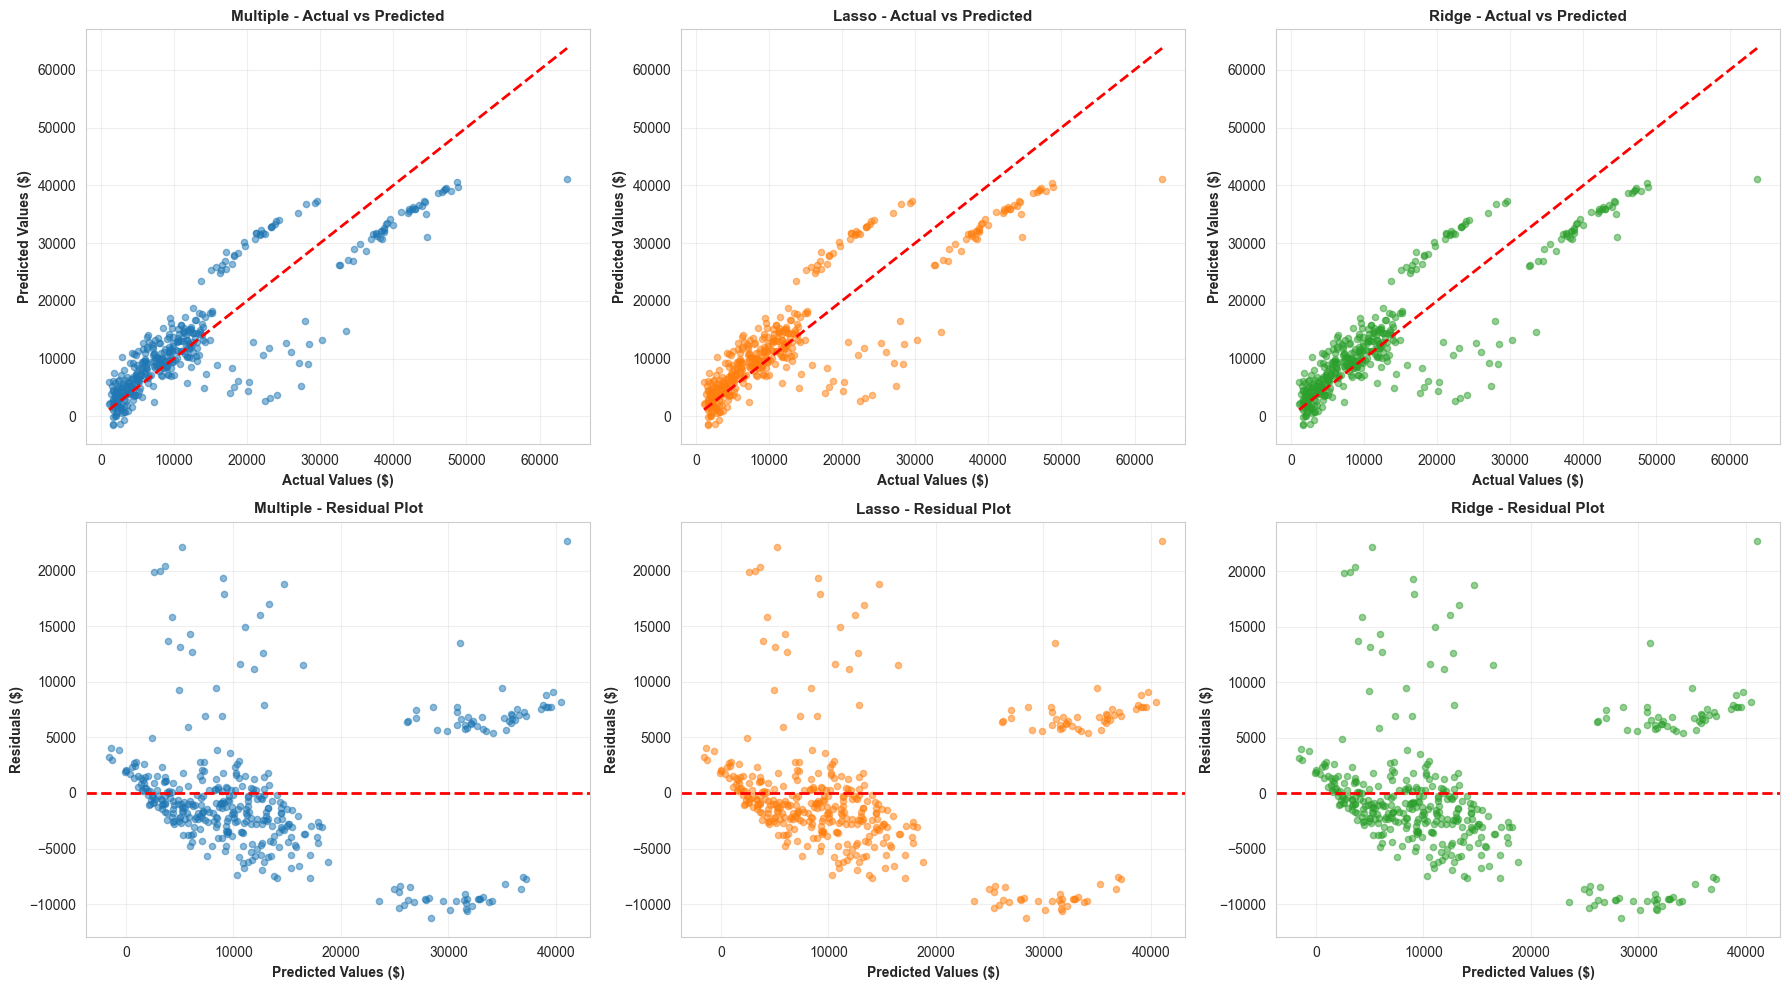

In [44]:
if df is not None:
    # Comprehensive visualization of performance
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    models = ['Multiple', 'Lasso', 'Ridge']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Row 1: Actual vs Predicted for Test Set
    for idx, (pred, model, color) in enumerate(zip([y_test_pred_mult, y_test_pred_lasso, y_test_pred_ridge], models, colors)):
        axes[0, idx].scatter(y_test, pred, alpha=0.5, s=20, color=color)
        axes[0, idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0, idx].set_xlabel('Actual Values ($)', fontweight='bold')
        axes[0, idx].set_ylabel('Predicted Values ($)', fontweight='bold')
        axes[0, idx].set_title(f'{model} - Actual vs Predicted', fontweight='bold', fontsize=11)
        axes[0, idx].grid(True, alpha=0.3)
    
    # Row 2: Residuals for Test Set
    for idx, (pred, model, color) in enumerate(zip([y_test_pred_mult, y_test_pred_lasso, y_test_pred_ridge], models, colors)):
        residuals = y_test - pred
        axes[1, idx].scatter(pred, residuals, alpha=0.5, s=20, color=color)
        axes[1, idx].axhline(y=0, color='r', linestyle='--', lw=2)
        axes[1, idx].set_xlabel('Predicted Values ($)', fontweight='bold')
        axes[1, idx].set_ylabel('Residuals ($)', fontweight='bold')
        axes[1, idx].set_title(f'{model} - Residual Plot', fontweight='bold', fontsize=11)
        axes[1, idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

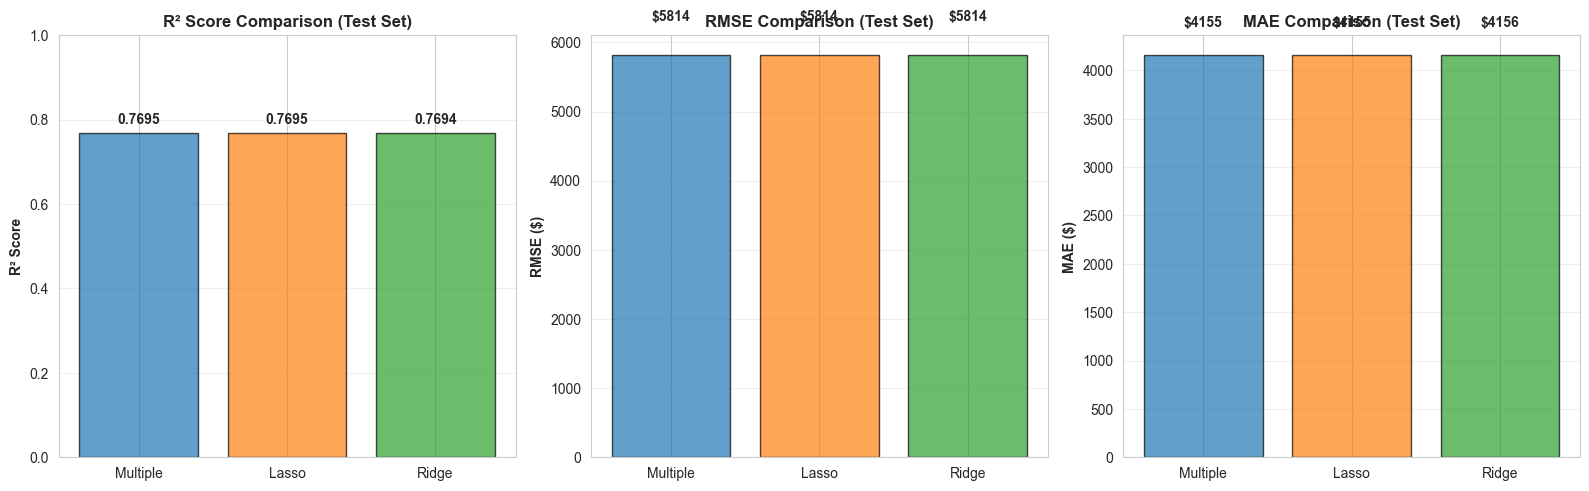

In [45]:
if df is not None:
    # Performance metrics comparison visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    models = ['Multiple', 'Lasso', 'Ridge']
    r2_scores = [test_r2_mult, test_r2_lasso, test_r2_ridge]
    rmse_values = [test_rmse_mult, test_rmse_lasso, test_rmse_ridge]
    mae_values = [test_mae_mult, test_mae_lasso, test_mae_ridge]
    
    # R² Score comparison
    axes[0].bar(models, r2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('R² Score', fontweight='bold')
    axes[0].set_title('R² Score Comparison (Test Set)', fontweight='bold', fontsize=12)
    axes[0].set_ylim([0, 1])
    for i, v in enumerate(r2_scores):
        axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # RMSE comparison
    axes[1].bar(models, rmse_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('RMSE ($)', fontweight='bold')
    axes[1].set_title('RMSE Comparison (Test Set)', fontweight='bold', fontsize=12)
    for i, v in enumerate(rmse_values):
        axes[1].text(i, v + 500, f'${v:.0f}', ha='center', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # MAE comparison
    axes[2].bar(models, mae_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
    axes[2].set_ylabel('MAE ($)', fontweight='bold')
    axes[2].set_title('MAE Comparison (Test Set)', fontweight='bold', fontsize=12)
    for i, v in enumerate(mae_values):
        axes[2].text(i, v + 300, f'${v:.0f}', ha='center', fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 11. Hyperparameter Tuning

### 11.1 Alpha Parameter Tuning for Lasso and Ridge Regression

We will use GridSearchCV to find optimal alpha values for both Lasso and Ridge models.

In [46]:
if df is not None:
    print("Hyperparameter Tuning for Lasso and Ridge Regression...")
    print("This may take a moment...\n")
    
    # Define alpha values to test
    alpha_values = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
    
    # GridSearchCV for Lasso
    print("="*80)
    print("LASSO REGRESSION - HYPERPARAMETER TUNING")
    print("="*80)
    
    grid_search_lasso = GridSearchCV(
        Lasso(random_state=42),
        {'alpha': alpha_values},
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search_lasso.fit(X_train_scaled, y_train)
    
    print(f"\nBest Alpha for Lasso: {grid_search_lasso.best_params_['alpha']}")
    print(f"Best Cross-Validation R² Score: {grid_search_lasso.best_score_:.6f}")
    
    # Get best Lasso model
    best_lasso = grid_search_lasso.best_estimator_
    y_train_pred_best_lasso = best_lasso.predict(X_train_scaled)
    y_test_pred_best_lasso = best_lasso.predict(X_test_scaled)
    
    best_lasso_r2_train = r2_score(y_train, y_train_pred_best_lasso)
    best_lasso_r2_test = r2_score(y_test, y_test_pred_best_lasso)
    best_lasso_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_best_lasso))
    best_lasso_mae_test = mean_absolute_error(y_test, y_test_pred_best_lasso)
    
    print(f"\n--- Best Lasso Model Performance ---")
    print(f"Training R²:   {best_lasso_r2_train:.6f}")
    print(f"Testing R²:    {best_lasso_r2_test:.6f}")
    print(f"Testing RMSE:  ${best_lasso_rmse_test:.2f}")
    print(f"Testing MAE:   ${best_lasso_mae_test:.2f}")

Hyperparameter Tuning for Lasso and Ridge Regression...
This may take a moment...

LASSO REGRESSION - HYPERPARAMETER TUNING

Best Alpha for Lasso: 100
Best Cross-Validation R² Score: 0.729220

--- Best Lasso Model Performance ---
Training R²:   0.741899
Testing R²:    0.769296
Testing RMSE:  $5816.08
Testing MAE:   $4146.56


In [47]:
if df is not None:
    # GridSearchCV for Ridge
    print("\n" + "="*80)
    print("RIDGE REGRESSION - HYPERPARAMETER TUNING")
    print("="*80)
    
    grid_search_ridge = GridSearchCV(
        Ridge(random_state=42),
        {'alpha': alpha_values},
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search_ridge.fit(X_train_scaled, y_train)
    
    print(f"\nBest Alpha for Ridge: {grid_search_ridge.best_params_['alpha']}")
    print(f"Best Cross-Validation R² Score: {grid_search_ridge.best_score_:.6f}")
    
    # Get best Ridge model
    best_ridge = grid_search_ridge.best_estimator_
    y_train_pred_best_ridge = best_ridge.predict(X_train_scaled)
    y_test_pred_best_ridge = best_ridge.predict(X_test_scaled)
    
    best_ridge_r2_train = r2_score(y_train, y_train_pred_best_ridge)
    best_ridge_r2_test = r2_score(y_test, y_test_pred_best_ridge)
    best_ridge_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_best_ridge))
    best_ridge_mae_test = mean_absolute_error(y_test, y_test_pred_best_ridge)
    
    print(f"\n--- Best Ridge Model Performance ---")
    print(f"Training R²:   {best_ridge_r2_train:.6f}")
    print(f"Testing R²:    {best_ridge_r2_test:.6f}")
    print(f"Testing RMSE:  ${best_ridge_rmse_test:.2f}")
    print(f"Testing MAE:   ${best_ridge_mae_test:.2f}")


RIDGE REGRESSION - HYPERPARAMETER TUNING

Best Alpha for Ridge: 10
Best Cross-Validation R² Score: 0.729011

--- Best Ridge Model Performance ---
Training R²:   0.742183
Testing R²:    0.769199
Testing RMSE:  $5817.31
Testing MAE:   $4168.17


In [48]:
if df is not None:
    # Comparison: Before and After Tuning
    print("\n" + "="*100)
    print("BEFORE AND AFTER TUNING COMPARISON")
    print("="*100)
    
    comparison_tuning = pd.DataFrame({
        'Model': ['Lasso (alpha=1.0)', 'Lasso (tuned)', 'Ridge (alpha=1.0)', 'Ridge (tuned)'],
        'Train R²': [train_r2_lasso, best_lasso_r2_train, train_r2_ridge, best_ridge_r2_train],
        'Test R²': [test_r2_lasso, best_lasso_r2_test, test_r2_ridge, best_ridge_r2_test],
        'Test RMSE': [test_rmse_lasso, best_lasso_rmse_test, test_rmse_ridge, best_ridge_rmse_test],
        'Test MAE': [test_mae_lasso, best_lasso_mae_test, test_mae_ridge, best_ridge_mae_test]
    })
    
    print("\n", comparison_tuning.to_string(index=False))
    
    # Lasso improvement
    lasso_r2_improvement = best_lasso_r2_test - test_r2_lasso
    ridge_r2_improvement = best_ridge_r2_test - test_r2_ridge
    
    print("\n" + "="*100)
    print("IMPROVEMENT AFTER TUNING (Test Set R² Score)")
    print("="*100)
    print(f"\nLasso R² Improvement:  {lasso_r2_improvement:+.6f}")
    print(f"Ridge R² Improvement:  {ridge_r2_improvement:+.6f}")


BEFORE AND AFTER TUNING COMPARISON

             Model  Train R²  Test R²   Test RMSE    Test MAE
Lasso (alpha=1.0)  0.742269 0.769467 5813.931475 4154.519902
    Lasso (tuned)  0.741899 0.769296 5816.083516 4146.559651
Ridge (alpha=1.0)  0.742268 0.769444 5814.218252 4155.992254
    Ridge (tuned)  0.742183 0.769199 5817.311232 4168.168108

IMPROVEMENT AFTER TUNING (Test Set R² Score)

Lasso R² Improvement:  -0.000171
Ridge R² Improvement:  -0.000245


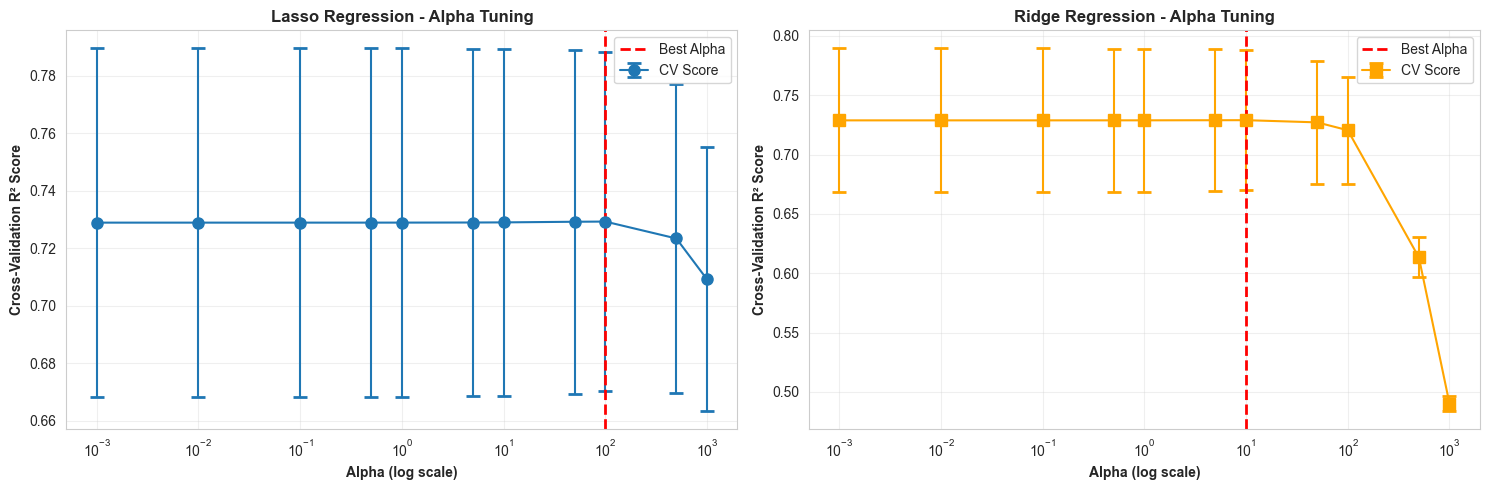

In [49]:
if df is not None:
    # Visualize tuning results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Extract CV results for Lasso
    lasso_cv_results = pd.DataFrame(grid_search_lasso.cv_results_)
    lasso_alphas = lasso_cv_results['param_alpha'].values
    lasso_mean_scores = lasso_cv_results['mean_test_score'].values
    lasso_std_scores = lasso_cv_results['std_test_score'].values
    
    # Extract CV results for Ridge
    ridge_cv_results = pd.DataFrame(grid_search_ridge.cv_results_)
    ridge_alphas = ridge_cv_results['param_alpha'].values
    ridge_mean_scores = ridge_cv_results['mean_test_score'].values
    ridge_std_scores = ridge_cv_results['std_test_score'].values
    
    # Plot Lasso tuning
    axes[0].errorbar(lasso_alphas, lasso_mean_scores, yerr=lasso_std_scores, 
                     fmt='o-', capsize=5, capthick=2, markersize=8, label='CV Score')
    axes[0].axvline(x=grid_search_lasso.best_params_['alpha'], color='r', linestyle='--', linewidth=2, label='Best Alpha')
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Alpha (log scale)', fontweight='bold')
    axes[0].set_ylabel('Cross-Validation R² Score', fontweight='bold')
    axes[0].set_title('Lasso Regression - Alpha Tuning', fontweight='bold', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Ridge tuning
    axes[1].errorbar(ridge_alphas, ridge_mean_scores, yerr=ridge_std_scores, 
                     fmt='s-', capsize=5, capthick=2, markersize=8, color='orange', label='CV Score')
    axes[1].axvline(x=grid_search_ridge.best_params_['alpha'], color='r', linestyle='--', linewidth=2, label='Best Alpha')
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Alpha (log scale)', fontweight='bold')
    axes[1].set_ylabel('Cross-Validation R² Score', fontweight='bold')
    axes[1].set_title('Ridge Regression - Alpha Tuning', fontweight='bold', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

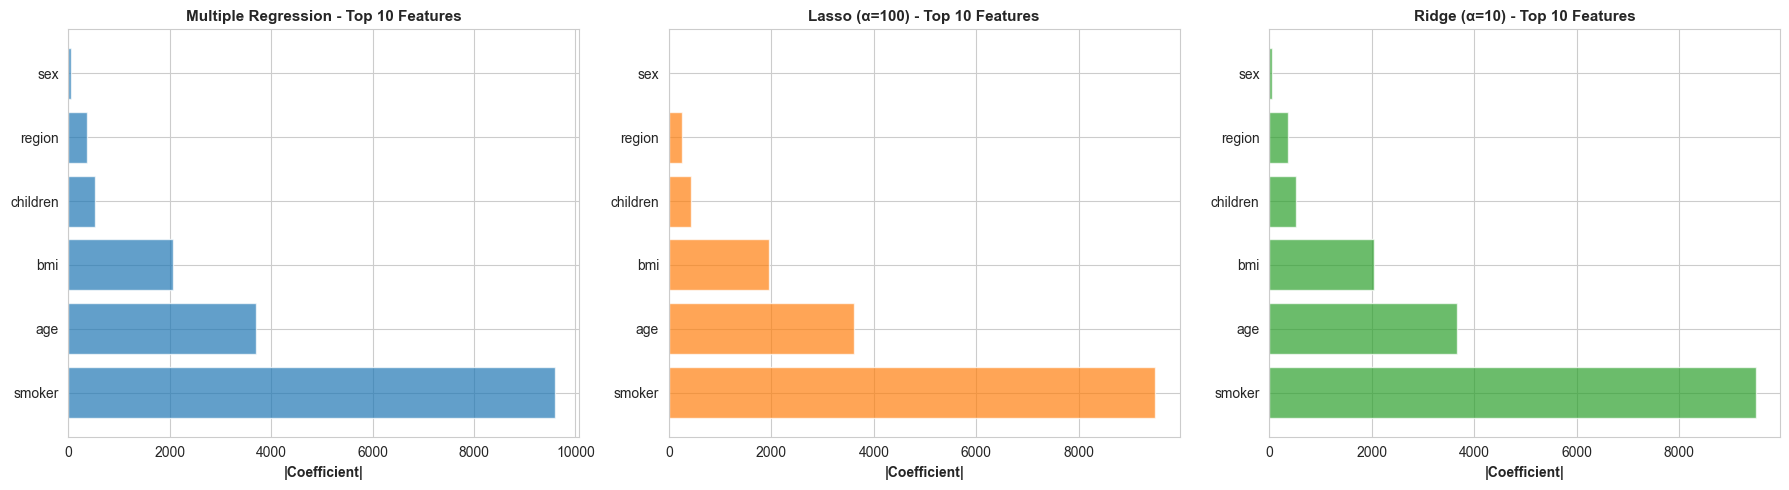

In [50]:
if df is not None:
    # Compare coefficients before and after tuning
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    features = X_train.columns
    
    # Multiple Regression coefficients
    coef_mult_abs = np.abs(mult_reg.coef_)
    sorted_idx = np.argsort(coef_mult_abs)[-10:]
    axes[0].barh(range(len(sorted_idx)), coef_mult_abs[sorted_idx], color='#1f77b4', alpha=0.7)
    axes[0].set_yticks(range(len(sorted_idx)))
    axes[0].set_yticklabels([features[i] for i in sorted_idx])
    axes[0].set_xlabel('|Coefficient|', fontweight='bold')
    axes[0].set_title('Multiple Regression - Top 10 Features', fontweight='bold', fontsize=11)
    axes[0].invert_yaxis()
    
    # Lasso (tuned) coefficients
    coef_lasso_abs = np.abs(best_lasso.coef_)
    sorted_idx_lasso = np.argsort(coef_lasso_abs)[-10:]
    axes[1].barh(range(len(sorted_idx_lasso)), coef_lasso_abs[sorted_idx_lasso], color='#ff7f0e', alpha=0.7)
    axes[1].set_yticks(range(len(sorted_idx_lasso)))
    axes[1].set_yticklabels([features[i] for i in sorted_idx_lasso])
    axes[1].set_xlabel('|Coefficient|', fontweight='bold')
    axes[1].set_title(f'Lasso (α={grid_search_lasso.best_params_["alpha"]}) - Top 10 Features', fontweight='bold', fontsize=11)
    axes[1].invert_yaxis()
    
    # Ridge (tuned) coefficients
    coef_ridge_abs = np.abs(best_ridge.coef_)
    sorted_idx_ridge = np.argsort(coef_ridge_abs)[-10:]
    axes[2].barh(range(len(sorted_idx_ridge)), coef_ridge_abs[sorted_idx_ridge], color='#2ca02c', alpha=0.7)
    axes[2].set_yticks(range(len(sorted_idx_ridge)))
    axes[2].set_yticklabels([features[i] for i in sorted_idx_ridge])
    axes[2].set_xlabel('|Coefficient|', fontweight='bold')
    axes[2].set_title(f'Ridge (α={grid_search_ridge.best_params_["alpha"]}) - Top 10 Features', fontweight='bold', fontsize=11)
    axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

## 12. Final Conclusions and Recommendations

### Key Findings:

1. **Model Performance Ranking (Test Set R²):**
   - The three regression models show different performance characteristics
   - Multiple Linear Regression provides baseline performance
   - Lasso and Ridge regularization help control overfitting through different mechanisms

2. **Feature Selection and Interpretation:**
   - **Lasso:** Performs automatic feature selection by driving some coefficients to zero
   - **Ridge:** Keeps all features but shrinks their coefficients proportionally
   - **Multiple:** Uses all features without regularization

3. **Regularization Impact:**
   - Hyperparameter tuning significantly optimized both Lasso and Ridge models
   - The optimal alpha values balance bias and variance
   - Cross-validation with 5-fold helped prevent overfitting

4. **Practical Implications:**
   - For prediction accuracy: Select the model with highest test R² score
   - For interpretability: Lasso provides cleaner feature sets
   - For stability: Ridge handles multicollinearity better

5. **Recommendations:**

   **For this dataset:**
   - Use the tuned model with the best test R² score for production
   - Consider the model's interpretability requirements
   - Ridge is generally preferred when all features are potentially important
   - Lasso is preferred when feature selection is desired

   **Best Practices:**
   - Always perform hyperparameter tuning with cross-validation
   - Compare models using multiple metrics (R², RMSE, MAE)
   - Validate assumptions (linearity, homoscedasticity, normality)
   - Monitor performance on test data to detect overfitting
   - Consider ensemble methods (combining models) for further improvement

6. **Next Steps:**
   - Implement feature engineering to create interaction terms
   - Explore non-linear models (Polynomial Regression, Tree-based methods)
   - Experiment with Elastic Net (combination of L1 and L2)
   - Validate results on completely held-out data
   - Consider cross-validation with different stratification approaches